In [61]:
%pylab inline
import multiprocessing as mp
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.8,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = ['H','He','C','N','O','Ne','Mg','Si','Fe']

# Producing the SSP birth elemental fractions (here we use solar)
solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

In [56]:
# yieldset default
a.yield_table_name_sn2 = 'TNG_net'
a.yield_table_name_agb = 'TNG_net'
a.yield_table_name_1a = 'TNG'

# imf parameters
a.only_net_yields_in_process_tables = True
a.imf_type_name = 'Chabrier_2'
#default
a.high_mass_slope = -2.3
a.imf_parameter = (22.8978, 716.4, 0.25, a.high_mass_slope)
a.mmin = 0.1
a.mmax = 100
# 100,000,000 mass steps are smooth enough for 1000 time steps
a.mass_steps = 200000 #2000 # 200000
a.sn2mmin = 8.
a.sn2mmax = 100.
a.bhmmin = float(a.sn2mmax) ## maximum of hypernova
a.bhmmax = float(a.mmax) ## maximum of the IMF

# sn1a delay parameters for maoz
#default
a.N_0 = 0.0012882#np.power(10,-2.89)
a.sn1a_time_delay = 0.04#np.power(10,-0.8)
#alternative
#a.N_0 = np.power(10,-3.49)
#a.sn1a_time_delay = np.power(10,-0.88)

a.sn1a_exponent = 1.12
a.dummy = 0.0
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

In [57]:
list_of_metallicities = [0.02]#np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap


def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    print(metallicity,a.yield_table_name_sn2)
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [59]:
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)

0.02 TNG_net


In [60]:
x['unprocessed_ejecta']

ValueError: no field of name unprocessed_ejecta

In [22]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
x = list_of_SSP_tables[2][0]

the data type of the SSP yield table:  (numpy.record, [('mass_of_ms_stars_dying', '<f8'), ('mass_in_ms_stars', '<f8'), ('mass_in_remnants', '<f8'), ('sn2', '<f8'), ('sn1a', '<f8'), ('pn', '<f8'), ('bh', '<f8'), ('hydrogen_mass_accreted_onto_white_dwarfs', '<f8'), ('H', '<f8'), ('He', '<f8'), ('C', '<f8'), ('N', '<f8'), ('O', '<f8'), ('Ne', '<f8'), ('Mg', '<f8'), ('Si', '<f8'), ('Fe', '<f8')])


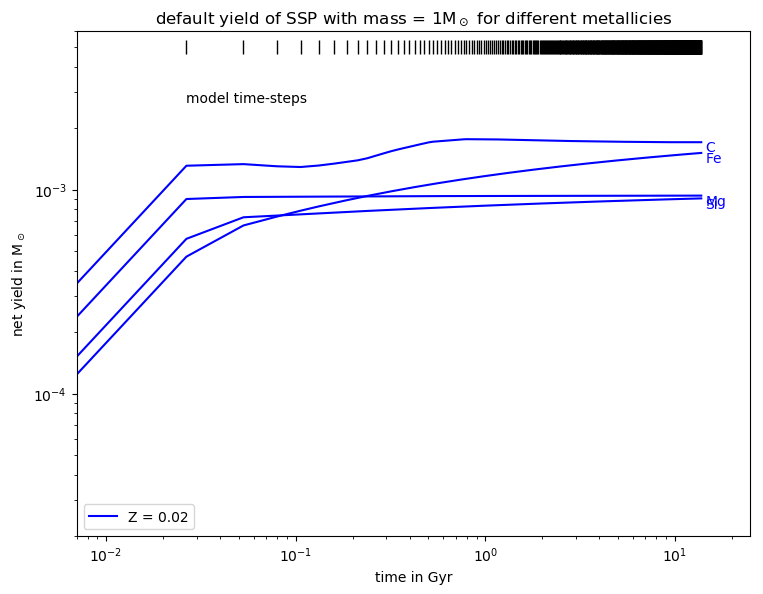

In [26]:
alpha = 0.5
factor = 1.05

## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(x["Fe"]),'b', label = 'Z = 0.02')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Fe"])*0.9) ,s = 'Fe',color = 'b')

ax.plot(time_steps,np.cumsum(x["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Mg"])*0.9) ,s = 'Mg',color = 'b')

ax.plot(time_steps,np.cumsum(x["Si"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Si"])*0.9) ,s = 'Si',color = 'b')

ax.plot(time_steps,np.cumsum(x["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["C"])*0.9) ,s = 'C',color = 'b')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'default yield of SSP with mass = 1M$_\odot$ for different metallicies')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [29]:
final_els=[]
for el in elements_to_trace:
    final_els.append(np.sum(x[el]))

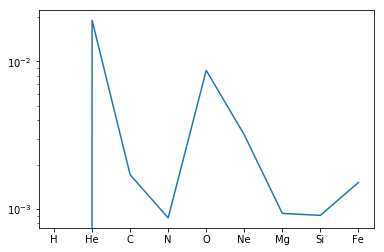

In [38]:
plt.plot(elements_to_trace,final_els)
plt.yscale('log');